#### Script 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
%matplotlib inline

SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches


# script 2 - takes in standards.txt and a list of FITS files
#
# write out for each image:
# loop throuhg the standards stars:
#     find the photometry from the current FITS image
#     IF star is not found (or bad data) write out NaN in the column
#
# write out for each image file:
#
# the name of the image file, the EPOCH, the FILTER, the AIRMASS, the FLUX and FLUXERR of J0600, (FLUX and FLUXERR for 20 stars)
# use and ECSV format (because it remembers the names of the columns and deals with 'Quantity' columns too....)


# make a plot of flux versus epoch (which is in MJD) for 

In [3]:
# First write out for one file:
#  the name of the image file, the EPOCH, the FILTER, the AIRMASS, the FLUX and FLUXERR of J0600, (FLUX and FLUXERR for 20 stars)
#  use and ECSV format (because it remembers the names of the columns and deals with 'Quantity' columns too....)

standards = ascii.read("standards.txt", guess=False)
coord_world = np.array([standards['RA'],standards['Dec']]).transpose()
nr_stars = len(coord_world[:,0])
print('Number of stars = {}'.format(nr_stars))


filename = '..//data/coj1m003-fa19-20210112-0083-e91.fits.fz'

hdu1 = fits.open(filename)

imh = hdu1['SCI'].header
phot = hdu1['cat'].data

epoch = imh['MJD-OBS']
obs_filter = imh['FILTER']
airmass = imh['AIRMASS']
pix_asec = imh['PIXSCALE'] # Nominal pixel scale on sky [arcsec/pixel]
print('Epoch = {:.5f} MJD'.format(epoch))
print('Filter = {}'.format(obs_filter))
print('AIRMASS = {:.5f}'.format(airmass))

Number of stars = 161
Epoch = 59226.45471 MJD
Filter = gp
AIRMASS = 1.07476


In [4]:
# Transform coordinates from realworld to pixels in image
w = wcs.WCS(hdu1['SCI'].header)

coord = w.wcs_world2pix(coord_world,0)

Set OBSGEO-B to   -31.273025 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


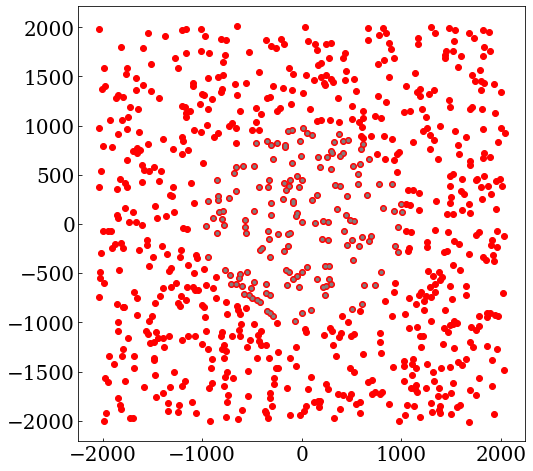

In [6]:
# functie(lijst met pixel_coordinaten van standards, lijst met pixel coordinaten huidige sterren):
#   reken afstanden uit
#   Test of afstand voldoende klein is (print afstanden)
#   
#   return index dichtbijzijndste ster voor elke ingevoerde ster

def find_stars(xobj_list, yobj_list, xlist, ylist):
    #print (xobj_list)
    #print (yobj_list)
    #print (xlist)
    #print (ylist)
    plt.figure(figsize=(8,8))
    plt.scatter(xlist-2048,ylist-2048,c='r',)
    plt.scatter(xobj_list-2048, yobj_list-2048, c='grey',marker='.')
    #plt.axis(xmin=-800,xmax=800,ymin=-800,ymax=800)
    plt.show()
    
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    
    return indices, np.diag(distance_matrix[indices]) #the daigonal gives the distance from each point to the star


stars_arg, d = find_stars(coord[:,0],coord[:,1], phot['x'], phot['y'])

In [5]:
# Getting the flux & fluxerr values for the different stars
flux_stars = phot['flux'][stars_arg]
fluxerr_stars = phot['fluxerr'][stars_arg]

In [6]:
newfilename = filename.replace('data','datared').replace('.fits.fz', '.txt')


#VERY cheap fix for "ValueError: Inconsistent data column lengths: {1, 44}", must be a better way
# maybe use 2 different files, maybe
nanlist = [np.NaN]*(nr_stars-1)

obj = [filename.replace('..//data/','').replace('fits.fz','')]
obj.extend(nanlist)
epoch = [imh['MJD-OBS']]
epoch.extend(nanlist)
obs_filter = [imh['FILTER']]
obs_filter.extend(nanlist)
airmass = [imh['AIRMASS']]
airmass.extend(nanlist)


# Write data to Table and then to file
filecontent = Table([obj, epoch, obs_filter, airmass, flux_stars, fluxerr_stars],\
                    names=['IMAGE','EPOCH','FILTER','AIRMASS','FLUX','FLUXERR'])
ascii.write(filecontent, newfilename, overwrite=True)

In [7]:
#use this code to select all images
from pathlib import Path

#selects all names in ../data/
for name in Path('..//data/').rglob('*e91.fits.fz'):
    print (name)
    print (str(name).replace('data','datared'))

../data/coj1m003-fa19-20210113-0098-e91.fits.fz
../datared/coj1m003-fa19-20210113-0098-e91.fits.fz
../data/coj1m011-fa12-20210111-0235-e91.fits.fz
../datared/coj1m011-fa12-20210111-0235-e91.fits.fz
../data/coj1m003-fa19-20210112-0084-e91.fits.fz
../datared/coj1m003-fa19-20210112-0084-e91.fits.fz
../data/coj1m003-fa19-20210117-0070-e91.fits.fz
../datared/coj1m003-fa19-20210117-0070-e91.fits.fz
../data/coj1m011-fa12-20210116-0174-e91.fits.fz
../datared/coj1m011-fa12-20210116-0174-e91.fits.fz
../data/lsc1m004-fa03-20210111-0142-e91.fits.fz
../datared/lsc1m004-fa03-20210111-0142-e91.fits.fz
../data/cpt1m012-fa06-20210118-0060-e91.fits.fz
../datared/cpt1m012-fa06-20210118-0060-e91.fits.fz
../data/lsc1m004-fa03-20210111-0141-e91.fits.fz
../datared/lsc1m004-fa03-20210111-0141-e91.fits.fz
../data/coj1m011-fa12-20210112-0135-e91.fits.fz
../datared/coj1m011-fa12-20210112-0135-e91.fits.fz
../data/coj1m003-fa19-20210113-0096-e91.fits.fz
../datared/coj1m003-fa19-20210113-0096-e91.fits.fz
../data/ls

In [8]:
names = []
names.append('d')
names.append(20)
names.append(814653.5)
print (names)

enzo = []
enzo.append('Units')
enzo.append(132)
enzo.append(1213.56146)

['d', 20, 814653.5]


In [35]:
AAAH = []
AAAH.append(names)
AAAH.append(enzo)
print (AAAH)


[['d', 20, 814653.5], ['Units', 132, 1213.56146]]
['d', 20, 814653.5]


In [31]:
from math import trunc

a = 12.3456789
print (trunc(a))
print (trunc(a*1e5)*1e-5)

12
12.34567


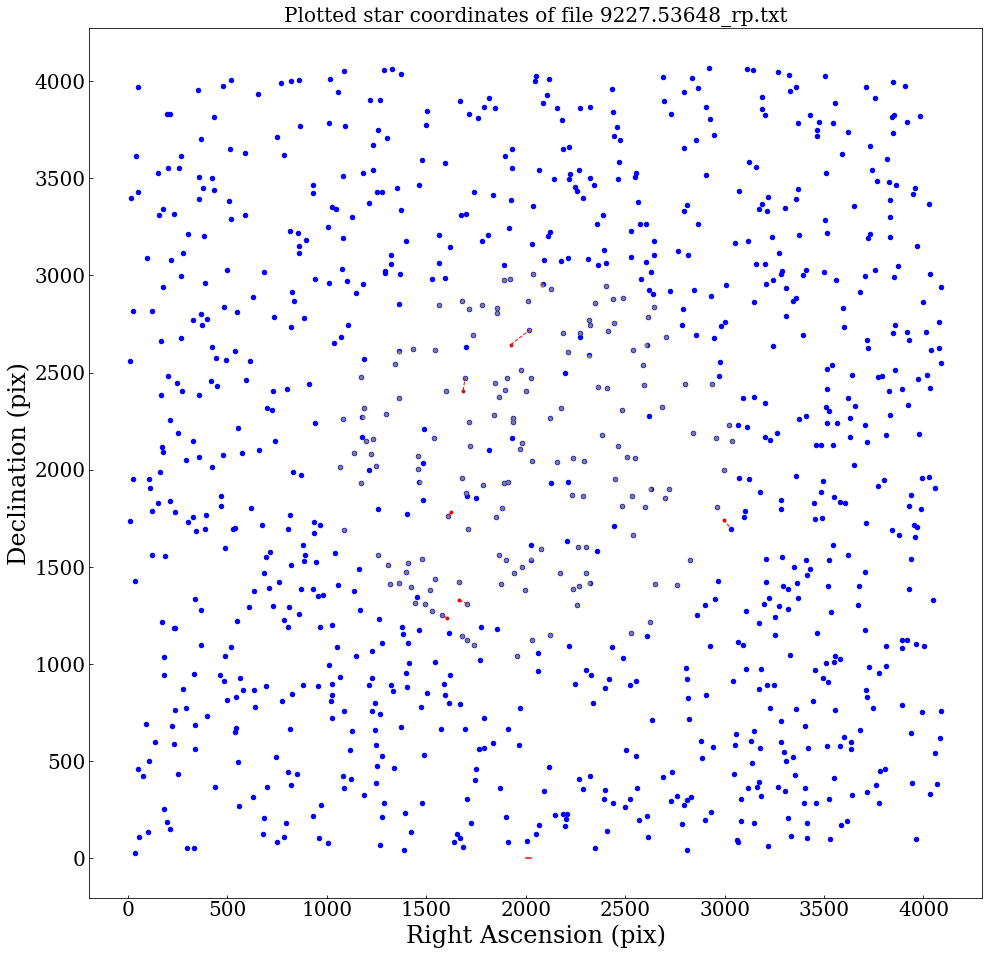

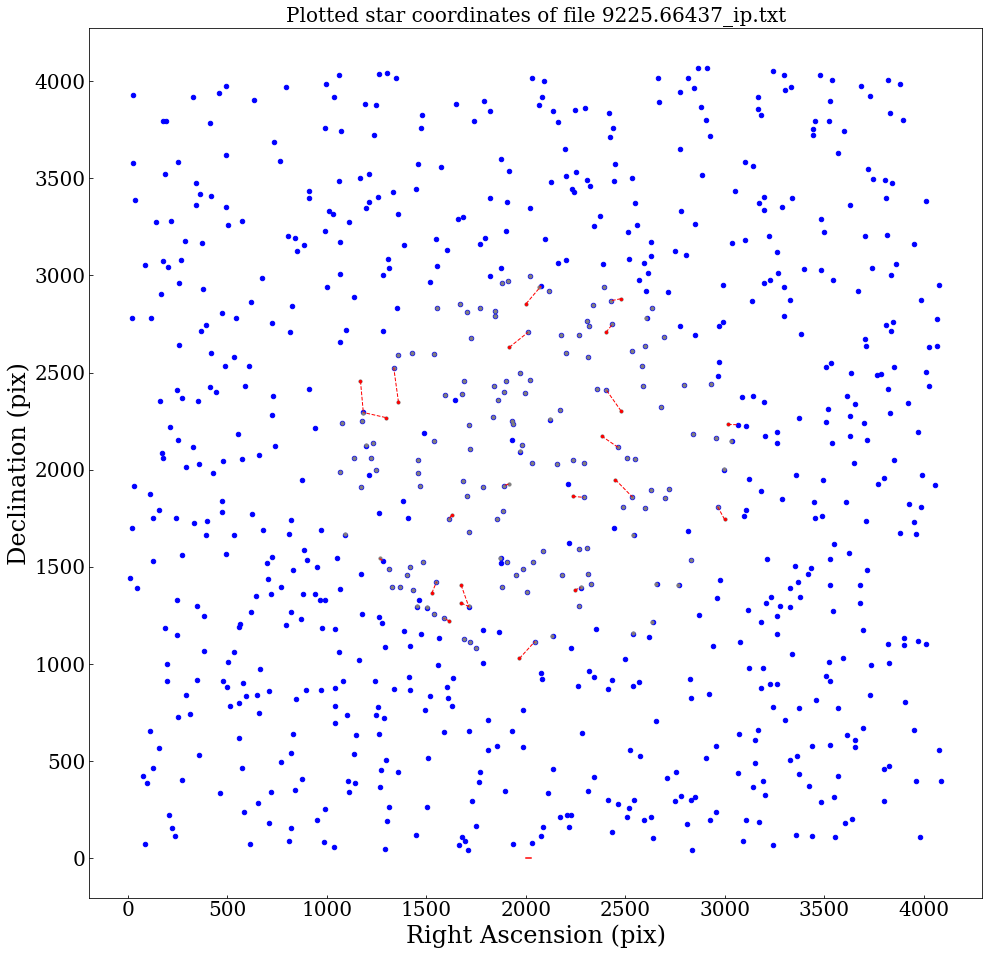

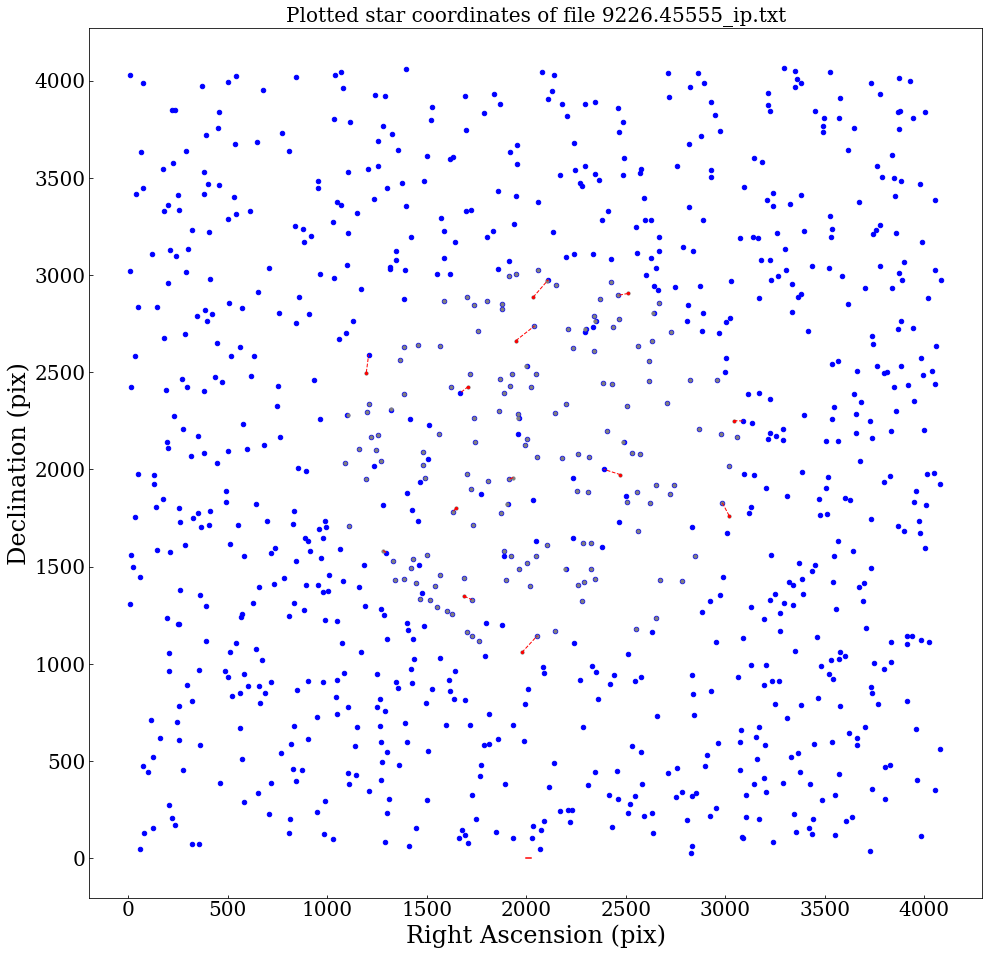

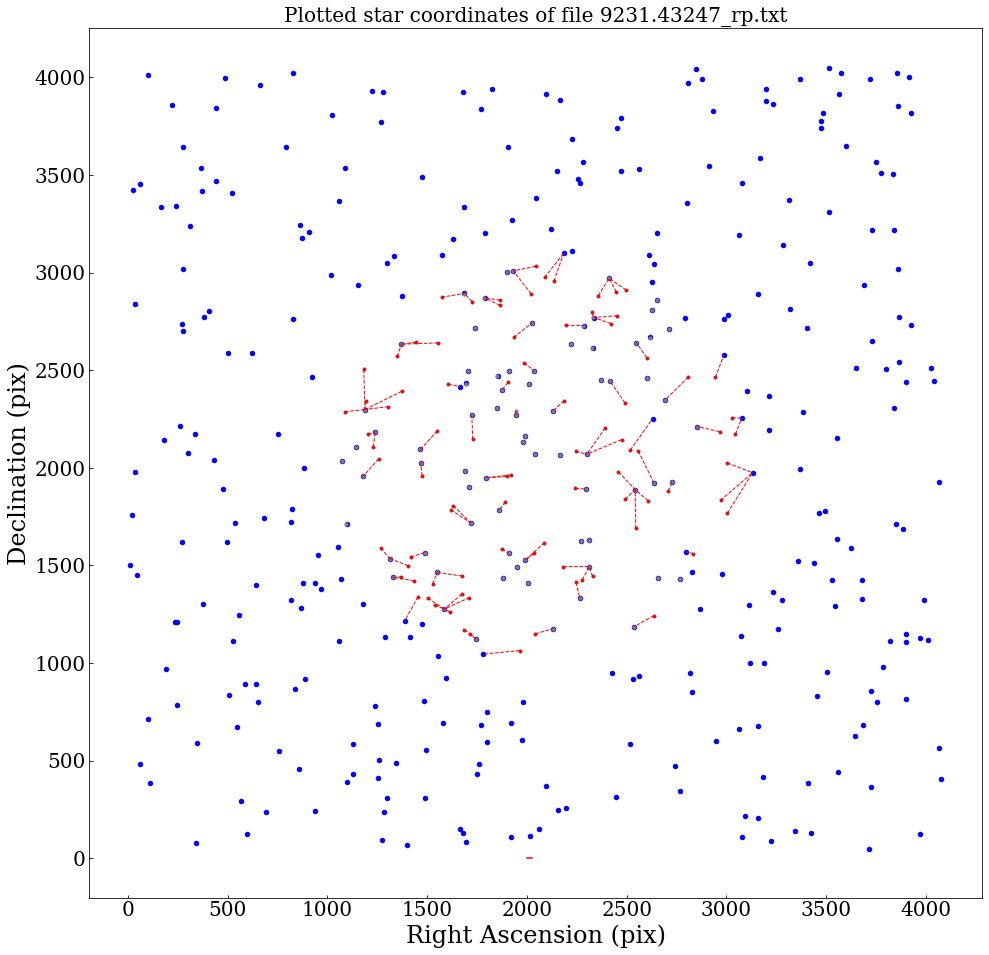

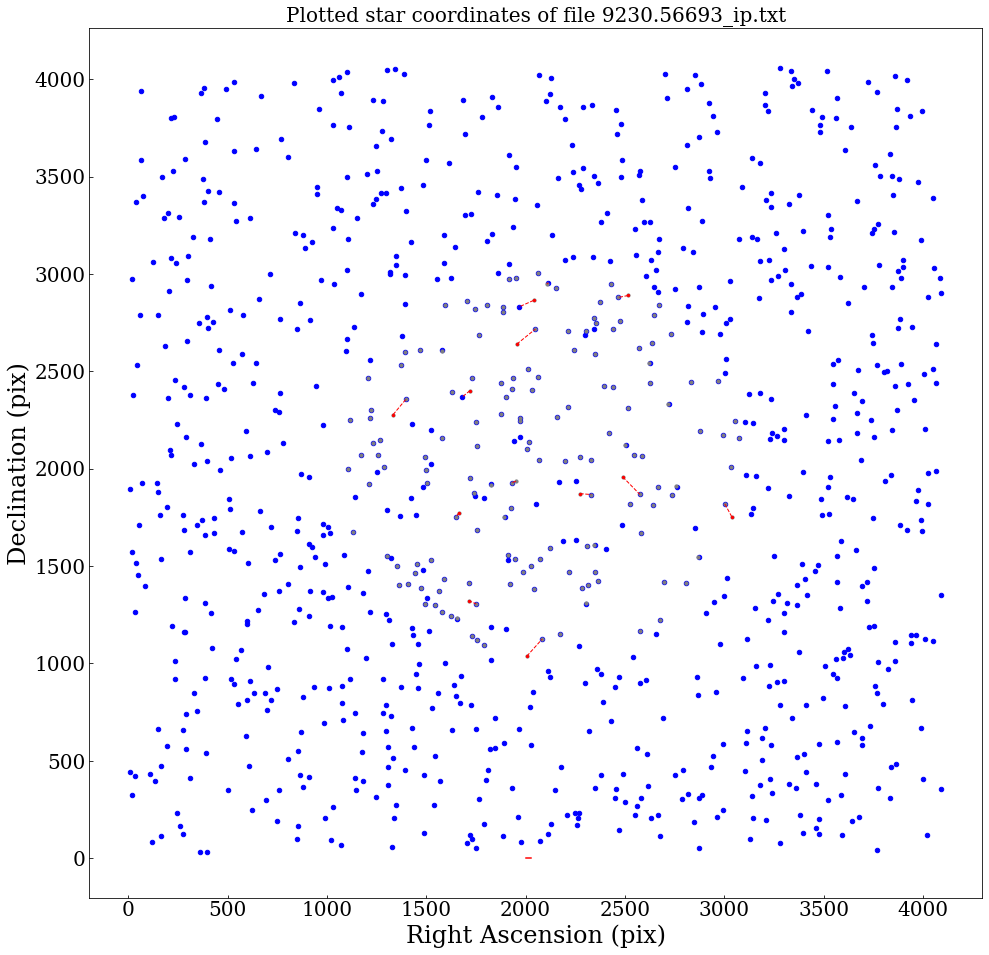

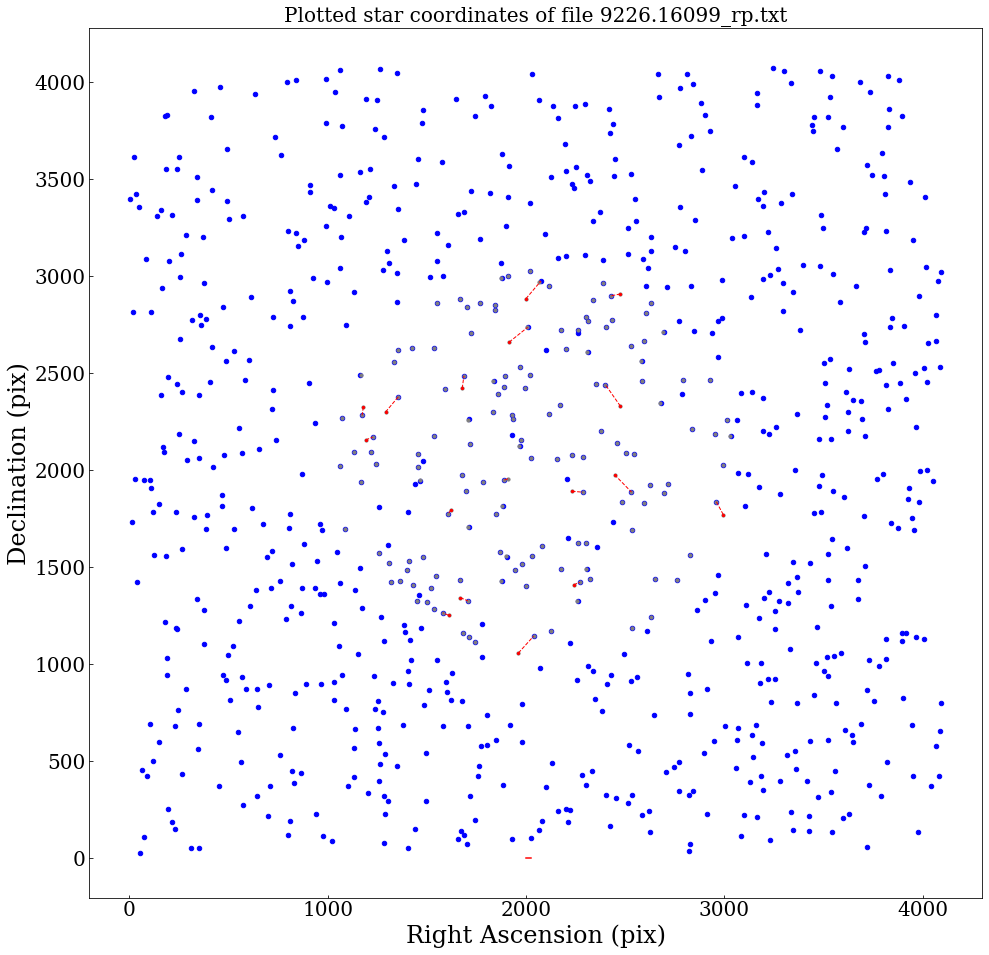

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc

# Import coordinates from selected objects
standards = ascii.read("standards.txt", guess=False)
coord_world = np.array([standards['RA'],standards['Dec']]).transpose()
nr_stars = len(coord_world[:,0])
#print('Number of stars = {}'.format(nr_stars))


def find_stars(xobj_list, yobj_list, xlist, ylist, f):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=20)
    plt.scatter(xobj_list, yobj_list, c='grey', s=10)
    tmpmask = np.diag(distance_matrix[indices]) > 25
    plt.scatter(xobj_list[tmpmask],yobj_list[tmpmask],c='r',s=5)
    
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title("Plotted star coordinates of file " + f[12:])
    plt.xlabel("Right Ascension (pix)")
    plt.ylabel("Declination (pix)")
    plt.show()
    
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

# Make one file with the image_name, epoch, filter and airmass
t_image, t_newimg, t_epoch, t_filter, t_airmass = [], [], [], [], []

#selects all names in ../data/
truncate = 0
for filename in Path('..//data/').rglob('*e91.fits.fz'):
    if truncate<6:
        truncate +=1
        filename = str(filename)
        #print (filename)
        # Open the file & extract certain data
        hdu1 = fits.open(filename)
        imh = hdu1['SCI'].header
        phot = hdu1['cat'].data

        # Getting the meta-data from the .fits file and writing it to lists
        epoch = imh['MJD-OBS']
        obs_filter = imh['FILTER']
        t_image.append(filename.replace('../data/',''))
        t_epoch.append(epoch)
        t_filter.append(obs_filter)
        t_airmass.append(imh['AIRMASS'])

        # Transform the world coordinates for the selected stars into pixel coordinates
        w = wcs.WCS(hdu1['SCI'].header)
        coord = w.wcs_world2pix(coord_world,0)

        # Make a new file path to write to with name= str( [EPOCH to 5 decimals (~1s)]_[FILTER])
        newfilename = '../datared/'+str(round(trunc(epoch*1e5)*1e-5,6)) + '_' + obs_filter + '.txt'
        t_newimg.append(newfilename)
        # Use the find_stars function to get the closest-star-indices for the selected stars
        stars_arg, d = find_stars(coord[:,0],coord[:,1], phot['x'], phot['y'], newfilename)

        # Use the indices to get the flux & fluxerr for all selected stars
        flux_stars = phot['flux'][stars_arg]
        fluxerr_stars = phot['fluxerr'][stars_arg]
        #if the distance is more than 25 pixels (~9.7"), it's too far away so it will write out NaN
        select_mask = d > 25
        flux_stars[select_mask] = np.NaN
        fluxerr_stars[select_mask] = np.NaN
